# Parallelization
When programming custom algorithms in python, it can happen that our code becomes slow because we run a couple of nested for-loops. If the inner loops do not depend on each other, code can be parallelized and sped up. Note, we are parallelizing code on a central processing unit (CPU) not not mix it up with GPU-acceleration that uses graphics processing units (GPUs).

In [1]:
import time
import numpy as np
from functools import partial
import timeit
import matplotlib.pyplot as plt
import platform

We start with an algorithm that does something with an image at given pixel coordinates

In [2]:
def slow_thing(image, x, y):
    # Silly algorithm for wasting compute time
    sum = 0
    for i in range(1000):
        for j in range(100):
            sum = sum + x
        sum = sum + y
    image[x, y] = sum

In [3]:
image = np.zeros((10, 10))

We now use [timeit](https://docs.python.org/3/library/timeit.html) to measure how long the operation takes for processing a single pixel.

In [4]:
%timeit slow_thing(image, 4, 5)

3.67 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We now define the operation on the whole image

In [5]:
def process_image(image):
    for x in range(image.shape[1]):
        for y in range(image.shape[1]):
            slow_thing(image, x, y)

We measure the time of this function as mentioned above

In [6]:
%timeit process_image(image)

372 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This function is quite slow and parallelization may make sense.

## Parallelization using joblib.Parallel
A simple and straightforward approach for parallelization is using [`joblib.Parallel`](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html) and `joblib.delayed`.

In [7]:
from joblib import Parallel, delayed, cpu_count

Note the reverse writing of the for loops in the following block. The term `delayed(slow_thing)(image, x, y)` is technially a function call, that is not executed. Later, when the return value of this call is actually needed, then the actualy execution will happen. See [dask delayed](https://docs.dask.org/en/stable/delayed.html) for details.

In [8]:
def process_image_parallel(image):
    Parallel(n_jobs=-1)(delayed(slow_thing)(image, x, y) 
                        for y in range(image.shape[0]) 
                        for x in range(image.shape[1]))

In [9]:
%timeit process_image_parallel(image)

59.1 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A speedup of 7 is not bad. The `n_jobs=-1` implies that all compute units / threads are used. We can also print out how many compute cores were used:

In [10]:
cpu_count()

10

For documentation purposes, we can also print out on what kind of CPU that algorithm was executed. This string might be more or less informative depending on what operating system / computer we are executing this notebook.

In [11]:
platform.processor()

'i386'

## Benchmarking execution time
In image processing, it is very common that execution time of algorithms shows different patterns depending on image size. We will now benchmark the algorithm above and see how it performs on differently sized images.
To bind a function to benchmark to a given image without executing it, we are using the [partial](https://docs.python.org/3/library/functools.html#functools.partial) pattern.

In [12]:
def benchmark(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 5) * 10

    benchmark_data = []

    for size in sizes:
        print("Size", size)

        # make new data
        image = np.zeros((size, size))
        
        # bind target function to given image
        partial_function = partial(target_function, image)

        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=10)
        print("time", time_in_s, "s")

        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

In [13]:
print("Benchmarking normal")
benchmark_data_normal = benchmark(process_image)
print("Benchmarking parallel")
benchmark_data_parallel = benchmark(process_image_parallel)

Benchmarking normal
Size 10
time 3.6755600420000007 s
Size 20
time 14.606198167 s
Size 30
time 32.68187025 s
Size 40
time 58.304140666 s
Benchmarking parallel
Size 10
time 0.6165027079999987 s
Size 20
time 2.0231766670000013 s
Size 30
time 4.416658041999995 s
Size 40
time 7.917167458000009 s


Text(0, 0.5, 'Compute time in s')

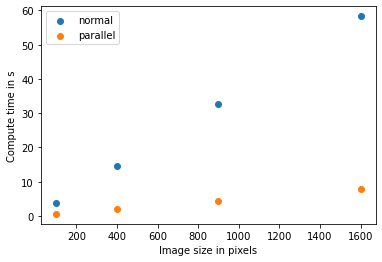

In [14]:
plt.scatter(benchmark_data_normal[:,0] ** 2, benchmark_data_normal[:,1])
plt.scatter(benchmark_data_parallel[:,0] ** 2, benchmark_data_parallel[:,1])
plt.legend(["normal", "parallel"])
plt.xlabel("Image size in pixels")
plt.ylabel("Compute time in s")
plt.show()

If we see this pattern, we speak of _linear_ relationship between data size and compute time. Computer scientists use the [O notation](https://en.wikipedia.org/wiki/Big_O_notation) to describe the [complexity](https://en.wikipedia.org/wiki/Computational_complexity) of algorithms. This algorithm has `O(n)` and `n` represents the number of pixels in this case.

Let's take a look at another algorithm.

In [15]:
def silly_sum(image):
    # Silly algorithm for wasting compute time
    sum = 0
    for i in range(image.shape[1]):
        for j in range(image.shape[0]):
            for k in range(image.shape[0]):
                for l in range(image.shape[0]):
                    sum = sum + image[i,j] - k + l
        sum = sum + i
        image[i, j] = sum / image.shape[1] / image.shape[0]

In [16]:
benchmark_data_silly_sum = benchmark(silly_sum)

Size 10
time 0.049324583000014854 s
Size 20
time 0.7592800000000182 s
Size 30
time 3.7161972079999828 s
Size 40
time 11.734440750000005 s


Text(0, 0.5, 'Compute time in s')

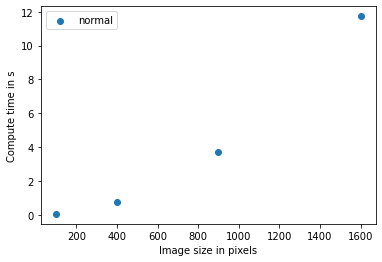

In [17]:
plt.scatter(benchmark_data_silly_sum[:,0] ** 2, benchmark_data_silly_sum[:,1])
plt.legend(["normal"])
plt.xlabel("Image size in pixels")
plt.ylabel("Compute time in s")
plt.show()

This algorithm is stronger dependent on image size, the plot shows approximately [quadratic](https://en.wikipedia.org/wiki/Time_complexity#Table_of_common_time_complexities) complexity. That means if the data size douples, the compute time multiplies by four. The algorithms O-notation is `O(n^2)`. We could presume that a similar algorithm applied in 3D has cubic complexity, `O(n^3)`. If such algorithms are bottlenecks in your science, parallelization and GPU-acceleration make a lot of sense.

## Code optimization using numba
In case the code we perform is simple and just uses standard python, numpy etc. function, we can use a just-in-time (JIT) compiler, e.g. provided by [numba](https://numba.pydata.org/) to speedup the code.

In [18]:
from numba import jit

@jit
def process_image_compiled(image):
    for x in range(image.shape[1]):
        for y in range(image.shape[1]):
            # Silly algorithm for wasting compute time
            sum = 0
            for i in range(1000):
                for j in range(1000):
                    sum = sum + x
                sum = sum + y
            image[x, y] = sum

In [19]:
%timeit process_image_compiled(image)

310 ns ± 0.827 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Quality assurance
Note that in this section we only measured conmpute time of algorithms. We did not determine if the differently optimized versions of the algorithms produce the same result. Quality assurance is good scientific practice. The same is relevant in the context of GPU-acceleration and for example described in detail [here](https://arxiv.org/pdf/2008.11799).

## Excercise: Parallelization
To practice parallelization, parallelize the function `silly_sum` shown above and plot its performance in comparison with the non-parallel version.